In [337]:
import torch
import pandas as pd
import torch
import torchvision
import albumentations as A
from tqdm.auto import tqdm
from typing import Callable

from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch import nn
import imageio.v3 as iio
# from PIL import Image
from pathlib import Path

In [338]:
# Upload data
train_image_bytes = pd.read_csv("../data/02_intermediate/train_image_bytes.csv")

In [339]:
class Config():
    ORIGINAL_IMAGE_SIZE = 512
    IMAGE_SIZE = 288
    TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
    N_TARGETS = len(TARGET_COLUMNS)
    BATCH_SIZE = 8
    BATCH_SIZE_VAL = 16
    N_VAL_SAMPLES = 4096
    LR_MAX = 3e-4
    WEIGHT_DECAY = 0.01
    N_EPOCHS = 12
    TRAIN_MODEL = True
    SEED = 42
    EPS = 1e-6
    EPS_CUDA = torch.tensor([EPS]).to('cuda')
    FEATURES = train_image_bytes.columns.tolist()[2:-14]
    N_FEATURES = len(FEATURES)

CONFIG = Config()

In [340]:
train, val = train_test_split(train_image_bytes, )
CONFIG.TARGET_MEDIANS = train[CONFIG.TARGET_COLUMNS].median(axis=0).values

In [341]:
train['file_path']

179    data/01_raw/train_images/196228846.jpeg
222     data/01_raw/train_images/28690128.jpeg
29     data/01_raw/train_images/185270359.jpeg
71     data/01_raw/train_images/196036657.jpeg
62     data/01_raw/train_images/195985005.jpeg
                        ...                   
189    data/01_raw/train_images/186660631.jpeg
149    data/01_raw/train_images/195741244.jpeg
131    data/01_raw/train_images/195663277.jpeg
72     data/01_raw/train_images/189930242.jpeg
2      data/01_raw/train_images/195760825.jpeg
Name: file_path, Length: 208, dtype: object

### VitLarge

In [342]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [343]:
example_data = {
    'image': torch.randn(1,3,288, 288).to(device),
    'feature': torch.randn(CONFIG.N_FEATURES).to(device)
}

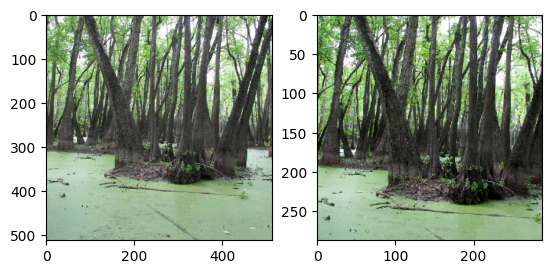

In [344]:
from torch.utils.data import Dataset, DataLoader
import imageio.v3 as iio
from pathlib import Path
import numpy as np


# Datasets
class MyDataset(Dataset):
    def __init__(
        self, 
        file_path: np.ndarray, 
        targets: np.ndarray, 
        features: np.ndarray, 
        transforms: A.Compose = None       
	):
        self.file_path = file_path
        self.targets = targets
        self.features = features
        self.transforms = transforms

    def __len__(self):
        return len(self.file_path)

    def __getitem__(self, index):
        X_sample = {
            'image': self.transforms(
                    image=iio.imread(Path("..", self.file_path[index])),
                )['image'],
            'feature': self.features[index],
        }
        y_sample = self.targets[index]
            
        return X_sample, y_sample

# Add augmentations
TRAIN_TRANSFORMS = A.Compose([
        A.RandomSizedCrop(
            [int(0.85*CONFIG.ORIGINAL_IMAGE_SIZE), CONFIG.ORIGINAL_IMAGE_SIZE],
            CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE, w2h_ratio=1.0, p=1.0
        ),
        A.HorizontalFlip(p=0.50),
        A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=0.50),
        A.ImageCompression(quality_lower=75, quality_upper=100, p=0.5),
        ToTensorV2(),
    ])

VAL_TEST_TRANSFORMS = A.Compose([
        A.Resize(CONFIG.IMAGE_SIZE,CONFIG.IMAGE_SIZE),
        ToTensorV2(),
    ])

# Visualize transformations
import matplotlib.pyplot as plt
example_image_path = train.file_path[0]
image_array = iio.imread(Path("..", example_image_path))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image_array)
axs[1].imshow(TRAIN_TRANSFORMS(image=image_array)['image'].permute(1,2,0))

train_dataset = MyDataset(
    train['file_path'].values,
    train[CONFIG.TARGET_COLUMNS].to_numpy(),
    train[CONFIG.FEATURES].to_numpy(),
    TRAIN_TRANSFORMS,
)

val_dataset = MyDataset(
    val['file_path'].values,
    val[CONFIG.TARGET_COLUMNS].to_numpy(),
    val[CONFIG.FEATURES].to_numpy(),
    VAL_TEST_TRANSFORMS,
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        drop_last=True,
        num_workers=1,
    )

val_dataloader = DataLoader(
    val_dataset,
    batch_size=CONFIG.BATCH_SIZE_VAL,
    drop_last=True,
    num_workers=1
)

In [345]:
X,y = next(iter(train_dataloader))
X['image'] = X['image'].to(device)
X['feature'] = X['feature'].to(device)
y = y.to(device)
X['image'].shape, X['feature'].shape, y.shape
isinstance(X['image'], torch.FloatTensor), isinstance(X['image'], torch.DoubleTensor), isinstance(X['image'], torch.LongTensor)

(False, False, False)

### Models

#### Vit Add

In [346]:
class ViTModelAdd(nn.Module):
    def __init__(self):
        super().__init__()
        
		# Pretrained feature extractor
        pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
        pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
        for parameter in pretrained_vit.parameters():
            parameter.requires_grad = False
        pretrained_vit.heads = nn.Linear(in_features = 768, out_features = 256).to(device)
		
		# Get automatic transforms from pretrained ViT weights
        pretrained_vit_transforms = pretrained_vit_weights.transforms()

        self.transformations = pretrained_vit_transforms
        self.feature_extractor = pretrained_vit
        self.mlp_regressor = nn.Sequential(
            nn.Linear(CONFIG.N_FEATURES, 256),
            nn.GELU(),
            nn.Linear(256, 256),
		)
        self.mlp_label = nn.Sequential(
            nn.Linear(256, 256),
            nn.GELU(),
            nn.Linear(256, CONFIG.N_TARGETS),
		)
        self.initialize_weights()
    def initialize_weights(self):
        nn.init.kaiming_uniform_(self.mlp_regressor[2].weight)
        nn.init.kaiming_uniform_(self.mlp_label[2].weight)
    def forward(self, inputs):
        return {
             'targets': self.mlp_label(
                 self.feature_extractor(self.transformations(inputs['image'].float())) + self.mlp_regressor(inputs['feature'].float())
			 )
		}

#### ViT concatenate

In [347]:
class ViTModelConcat(nn.Module):
    def __init__(self):
        super().__init__()
        
		# Pretrained feature extractor
        pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
        pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
        for parameter in pretrained_vit.parameters():
            parameter.requires_grad = False
        pretrained_vit.heads = nn.Linear(in_features = 768, out_features = 256).to(device)
		
		# Get automatic transforms from pretrained ViT weights
        pretrained_vit_transforms = pretrained_vit_weights.transforms()

        self.transformations = pretrained_vit_transforms
        self.feature_extractor = pretrained_vit
        self.mlp_regressor = nn.Sequential(
            nn.Linear(CONFIG.N_FEATURES, 256),
            nn.GELU(),
            nn.Linear(256, 256),
		)
        self.mlp_label = nn.Sequential(
            nn.Linear(256*2, 256),
            nn.GELU(),
            nn.Linear(256, CONFIG.N_TARGETS),
		)
        self.initialize_weights()
    def initialize_weights(self):
        nn.init.kaiming_uniform_(self.mlp_regressor[2].weight)
        nn.init.kaiming_uniform_(self.mlp_label[2].weight)
    def forward(self, inputs):
        # trans = self.feature_extractor(self.transformations(inputs['image'].float())).squeeze()
        # regr = self.mlp_regressor(inputs['feature'].float())
        # print(trans.shape)  
        # print(regr.shape)
        # print(torch.cat((trans, regr), dim=1).shape)
        return {
            'targets': self.mlp_label(
            torch.cat(
                (
                    self.feature_extractor(
                        self.transformations(inputs['image'].float())
					).squeeze(),
                    self.mlp_regressor(inputs['feature'].float())
                ), dim=1 
			)   
		)
		}

In [348]:
# model = ViTModelConcat().to(device)
model = ViTModelAdd().to(device)

#### Try forward pass on a single image

In [349]:
model.eval()
with torch.inference_mode():
    pred = model(X)

In [350]:
print(f"Output targets:\n{pred['targets'].shape}\n")

Output targets:
torch.Size([8, 6])



In [351]:
example_data['feature'].shape

torch.Size([163])

### Training and validation

In [352]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer
):
    model.train()
    train_loss = 0
    for batch, (X,y) in enumerate(dataloader):
        # print(f"Batch: {batch} of {len(dataloader)}")
        X['image']=X['image'].to(device)
        X['feature']=X['feature'].to(device) 
        y=y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred['targets'], y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss / len(dataloader)
    return train_loss

def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: Callable,
):
    model.eval()
    val_loss = 0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            # print(f"Batch: {batch}")
            X['image'], X['feature'], y= X['image'].to(device), X['feature'].to(device), y.to(device)
            val_preds = model(X)
            loss = loss_fn(val_preds['targets'], y)
            val_loss += loss.item()
    val_loss = val_loss / len(dataloader)
    return val_loss

In [353]:
# Loss function 
Y_MEDIAN = torch.tensor(CONFIG.TARGET_MEDIANS).to('cuda')
def r2_loss_fn(y_pred, y_true):
    ss_res = (y_true - y_pred)**2
    ss_total = (y_true - Y_MEDIAN)**2
    loss = torch.sum(ss_res, dim = 0) / torch.maximum(torch.sum(ss_total, dim=0), CONFIG.EPS_CUDA)
    return torch.mean(loss)

In [354]:
r2_loss_fn(pred['targets'], y)

tensor(590178.3943, device='cuda:0', dtype=torch.float64)

In [355]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model = ViTModelConcat().to(device)
loss_fn = r2_loss_fn
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=CONFIG.LR_MAX,
    weight_decay=CONFIG.WEIGHT_DECAY,
)

In [356]:
# train_loss = train_step(
#             model=model,
#             dataloader=train_dataloader,
#             loss_fn=loss_fn,
#             optimizer=optimizer
#         )

In [357]:
# val_loss = val_step(
#     model=model,
#     dataloader=val_dataloader,
#     loss_fn=loss_fn
# )

In [358]:
# model.eval()
# with torch.inference_mode():
#     pred = model(X)

In [359]:
# pred, y.float()

In [363]:
def train_model(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: Callable,
    epochs: int = 30
):
    results = {
        'train_loss': [],
        'validation_loss': []
    }

    for epoch in tqdm(range(epochs)):
        # print(epoch)
        train_loss = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer
        )
        val_loss = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn
        )

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"val_loss: {val_loss:.4f} | "
        )

        results['train_loss'].append(train_loss)
        results['validation_loss'].append(val_loss)

    return results

In [365]:
from timeit import default_timer as timer
start_time = timer()

model_results = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=30)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 14628.4206 | val_loss: 8690.5125 | 
Epoch: 2 | train_loss: 10853.0401 | val_loss: 11267.9491 | 
Epoch: 3 | train_loss: 9636.8287 | val_loss: 9045.7422 | 
Epoch: 4 | train_loss: 18002.3677 | val_loss: 6644.4644 | 
Epoch: 5 | train_loss: 14098.5413 | val_loss: 7722.1257 | 
Epoch: 6 | train_loss: 28811.1442 | val_loss: 4756.0595 | 
Epoch: 7 | train_loss: 21273.5468 | val_loss: 13084.9887 | 
Epoch: 8 | train_loss: 34763.0158 | val_loss: 2978.6161 | 
Epoch: 9 | train_loss: 22923.9918 | val_loss: 13801.3573 | 
Epoch: 10 | train_loss: 28250.5736 | val_loss: 3120.7421 | 
Epoch: 11 | train_loss: 7146.4504 | val_loss: 9849.7927 | 
Epoch: 12 | train_loss: 5749.2638 | val_loss: 2555.2373 | 
Epoch: 13 | train_loss: 2486.9066 | val_loss: 4429.9173 | 
Epoch: 14 | train_loss: 2869.4423 | val_loss: 2480.5082 | 
Epoch: 15 | train_loss: 4599.1218 | val_loss: 5643.6270 | 
Epoch: 16 | train_loss: 5986.6443 | val_loss: 4421.3616 | 
Epoch: 17 | train_loss: 7608.2186 | val_loss: 10043.5

In [368]:
model_results.keys()

dict_keys(['train_loss', 'validation_loss'])

In [369]:
from typing import List, Dict

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "test_loss": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    val_loss = results['validation_loss']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

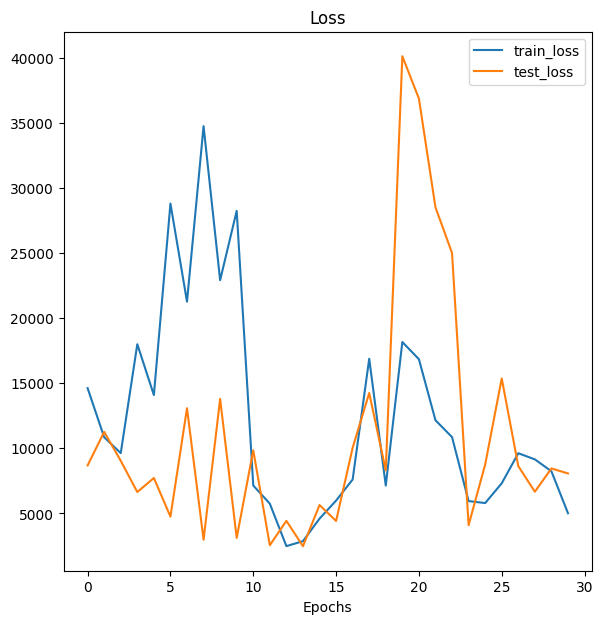

In [370]:
plot_loss_curves(model_results)